In [6]:
import torch as T
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import scipy.linalg
from functools import partial
%pylab
%matplotlib inline
import matplotlib as mpl
plt.ioff()
import matplotlib.gridspec as gridspec
import scipy.sparse as sparse
from scipy import stats
from __future__ import print_function
import gc
from tqdm import tqdm
from __future__ import division

Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['step']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


$x_{t+1} = (A + pB)x_t + Cu_{t+1}$

In [7]:
def passivity(t,k=0.05,t0=400):
    return 1/(1+np.exp(-k*(t-t0)))

def diag_idx(n):
    return [i for i in range(n)],[i for i in range(n)]

def makeStableMatrix(n, density=0.1):
    # TODO: implement on GPU?
    eig = np.diag(np.random.uniform(-1,0,n))
    v = scipy.linalg.orth(np.random.uniform(-1,1,(n,n)))
    A = np.matmul(np.matmul(v.T, eig), v)
    # need to make A sparse
    indices = np.reshape(np.indices((n,n)),[2,-1])
    mask = np.eye(n)
    # may create density slightly less than desired if choice is on diagonal
    idx = indices[:,np.random.choice(np.arange(indices.shape[1]),int(np.ceil(density*n**2-n)),replace=False)]
    mask[idx[0], idx[1]] = 1
    A[np.logical_not(mask)] = 0
    return A

def step(A,B,C,u,p,x,dt=1):
    dxdt = T.matmul((A + p*B), x) + C * u
    return dxdt + x

def step_batch(A,B,C,u,p,x,dt=1):
    dxdt = (T.matmul((A + p[:,None,None]*B), x[:,:,None])).squeeze() + u[:,None]*C
    return dxdt + x

def sim(A,B,C,u,p,x0,e=0.05):
    ntime = u.shape[0]
    nfeatures = x0.shape[0]
    time = T.arange(ntime,dtype=T.int32)
    x = T.zeros(ntime, x0.shape[0]).cuda()
    z = T.zeros(nfeatures).cuda()
    x[0] = x0
    for t in range(1,ntime):
        if e==0:
            x[t] = step(A,B,C,u[t],p[t],x[t-1])
        else:
            x[t] = step(A,B,C,u[t],p[t],x[t-1]) + T.normal(z,e).cuda()
    return x

def generate_data(sim_time, nstim,nfeatures, burn_in=400, test_time=200, e=0.01, k=0.05, t0=400, density=0.2):
    ntime = sim_time+burn_in+test_time
    time = T.from_numpy(np.arange(ntime)).cuda()
    A_true = T.from_numpy(makeStableMatrix(nfeatures,density).astype(np.float32)).cuda()
    B_true = T.from_numpy(makeStableMatrix(nfeatures,density).astype(np.float32)).cuda()
    C_true = T.from_numpy(np.random.normal(0,0.05,nfeatures).astype(np.float32)).cuda()
    # C_true = T.from_numpy(makeStableMatrix(nfeatures).astype(np.float32)).cuda()
    x0 = T.from_numpy(np.random.normal(0,0.05,nfeatures).astype(np.float32)).cuda()
    u = T.zeros(ntime).cuda()
    u[np.arange(4,ntime,ntime/nstim)] = 1

    p1 = np.vectorize(partial(passivity,k=k,t0=t0))
    time = np.arange(ntime)
    p_true = p1(time).astype(np.float32)
    p_true = T.from_numpy(p_true).cuda()
#     p_true = T.zeros(ntime).cuda() # TODO remove me
    x_true = sim(A_true,B_true,C_true,u,p_true,x0,e)
    train = (time[burn_in:-test_time], u[burn_in:-test_time],
             p_true[burn_in:-test_time], x_true[burn_in:-test_time])
    test = (time[-test_time:], u[-test_time:], p_true[-test_time:], x_true[-test_time:])
    return A_true, B_true, C_true, train, test

In [8]:
class FishSeqData(Dataset):    
    def __init__(self, u, p, x,n_future_steps=1):
        self.x = nn.Parameter(x,requires_grad=False)
        self.p = nn.Parameter(p,requires_grad=False)
        self.u = nn.Parameter(u,requires_grad=False)
        self.nfeatures = x.shape[1]
        self.n_future_steps = n_future_steps
        
    def __len__(self):
        return len(self.x)-self.n_future_steps

    def __getitem__(self, idx):
        indices = slice(idx,idx+self.n_future_steps)
        x_true_indices = slice(idx+1,idx+self.n_future_steps+1)
        return (self.u[indices], self.p[indices],
                self.x[indices], self.x[x_true_indices])

class DynamicsSeq(nn.Module):
    def __init__(self, nfeatures, n_future_steps,dtype=T.float32, scale=1,std=0.1):
        super(DynamicsSeq, self).__init__()
        if dtype==T.float32:
            tensor = T.cuda.FloatTensor
        elif dtype==T.float16:
            tensor = T.cuda.HalfTensor
                
        self.A = nn.Parameter(tensor(nfeatures,nfeatures).normal_(std),requires_grad=True)
        self.B = nn.Parameter(tensor(nfeatures,nfeatures).normal_(std),requires_grad=True)
        self.C = nn.Parameter(tensor(nfeatures).normal_(std),requires_grad=True)
        self.n_future_steps = n_future_steps
        self.tensor = tensor
        self.scale = scale
        self.dtype = dtype

    def forward(self, u, p, x_true, n_future_steps=None):
        if n_future_steps==None:
            n_future_steps = self.n_future_steps
        x = self.tensor(x_true.shape[0], 1+x_true.shape[1], *x_true.shape[2:]).zero_()
        x[:,0] = x_true[:,0]
        for t in range(n_future_steps):
            u[ :,t,None]*self.C
            dxdt = (T.matmul((self.A + p[:,t,None,None]*self.B), x_true[:,t,:,None]).squeeze()) + u[ :,t,None]*self.C
            x[:,t+1] = dxdt + x[:,t]
        return x[:,1:]

class Dynamics(nn.Module):
    def __init__(self, nfeatures):
        super(Dynamics, self).__init__()
        self.A = nn.Parameter(T.normal(T.zeros(nfeatures,nfeatures),0.5),requires_grad=True)
        self.B = nn.Parameter(T.normal(T.zeros(nfeatures,nfeatures),0.5),requires_grad=True)
        self.C = nn.Parameter(T.normal(T.zeros(nfeatures),0.5),requires_grad=True)

    def forward(self, u, p, x):
        return (x[:,0] + (T.matmul((self.A + p[:,0,None,None]*self.B), x[:,0,:,None]).squeeze()) + u[:,0,None] * self.C)[:,None]


def train(model,data,nepochs=10, lambdaA=(1e-8, 1e-6), lambdaB=(1e-6, 1e-6), lr=0.1, verbose=True):
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)
    if verbose:
        A_loss = F.mse_loss(model.A.data,A_true)
        print("A_loss: {}".format(A_loss))
    cum_mse_loss = 0
    with T.no_grad():
        for batch_data in tqdm(dataloader):
            U,P,X, X_true = batch_data
            X_pred = model(U,P,X)
            cum_mse_loss += F.mse_loss(X_pred.float(),X_true.float())
    print("mse_loss: {}".format(cum_mse_loss/len(dataloader)))
    optimizer = T.optim.SGD(model.parameters(),lr=lr)
#     optimizer = T.optim.Adam(model.parameters(),lr=lr,amsgrad=True)
    for e in range(nepochs):
        if verbose:
            print("epoch {}: ".format(e), end="")
        cum_loss = 0
        cum_mse_loss = 0
        for batch_data in tqdm(dataloader):
            U,P,X, X_true = batch_data
            X_pred = model(U,P,X)
            l_A = lambdaA[0] * model.A.norm(1) + lambdaA[1] * model.A.norm(2)
            l_B = lambdaB[0] * model.B.norm(1) + lambdaB[1] * model.B.norm(2)
            mse_loss = F.mse_loss(X_pred,X_true)
            loss = mse_loss + l_A + l_B

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            cum_loss += float(loss)
            cum_mse_loss += float(mse_loss)
            del X_pred, U,P,X, X_true, mse_loss, l_A, l_B, loss
            gc.collect()
            torch.cuda.empty_cache()

        if verbose:
            A_loss = F.mse_loss(model.A.data,A_true)
            B_loss = F.mse_loss(model.B.data,B_true)
            C_loss = F.mse_loss(model.C.data,C_true)
            print("pred_loss: {}, A_loss: {}, B_loss: {}, C_loss: {}".format(cum_loss,A_loss,B_loss,C_loss))
        print("cum_loss: {}, mse_loss: {}".format(cum_loss,cum_mse_loss/len(dataloader)))
    
    if verbose:
        print("pred_loss: {}, A_loss: {}, B_loss: {}, C_loss: {}".format(cum_loss,A_loss,B_loss,C_loss))

def set_grad(params, params_with_grad):

    for param, param_w_grad in zip(params, params_with_grad):
        if param.grad is None:
            param.grad = torch.nn.Parameter(param.data.new().resize_(*param.data.size()))
        param.grad.data.copy_(param_w_grad.grad.data)
    
def train_fp16(model,data,nepochs=10, lambdaA=(1e-8, 1e-6), lambdaB=(1e-6, 1e-6), lr=0.1, verbose=True,loss_scale=1):
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)
    param_copy = [param.clone().type(torch.cuda.FloatTensor).detach() for param in model.parameters()]
    for batch_data in tqdm(dataloader):
            U,P,X, X_true = batch_data
            X_pred = model(U,P,X)
            mse_loss = F.mse_loss(X_pred.float(),X_true.float())
            print("pred loss: {}".format(mse_loss))
            break
    
    if verbose:
        A_loss = F.mse_loss(param_copy[0].data/model.scale,A_true)
        print("A_loss: {}".format(A_loss))
#         optimizer = T.optim.SGD(model.parameters(),lr=lr)
    for param in param_copy:
        param.requires_grad = True
    optimizer = torch.optim.SGD(param_copy, lr)
#     optimizer = T.optim.Adam(param_copy,lr=lr)
    nfeatures = model.A.shape[0]
#     nondiagonal = ~T.eye(nfeatures,dtype=T.uint8)
    for e in range(nepochs):
        if verbose:
            print("epoch {}: ".format(e), end="")
        cum_loss = 0
        for batch_data in tqdm(dataloader):
            U,P,X, X_true = batch_data
            X_pred = model(U,P,X)
            l_A = lambdaA[0] * model.A.float().norm(1) + lambdaA[1] * model.A.float().norm(2)
            l_B = lambdaB[0] * model.B.float().norm(1) + lambdaB[1] * model.B.float().norm(2)
#             l_A = lambdaA[0] * model.A[nondiagonal].float().norm(1) + lambdaA[1] * model.A[nondiagonal].float().norm(2)
#             l_B = lambdaB[0] * model.B.float().norm(1) + lambdaB[1] * model.B.float().norm(2)

            mse_loss = F.mse_loss(X_pred,X_true).float()
            loss = (mse_loss + l_A + l_B) * loss_scale

            model.zero_grad()
            loss.backward()
            set_grad(param_copy, list(model.parameters()))
            if loss_scale != 1:
                for param in param_copy:
                    param.grad.data = param.grad.data/loss_scale
            optimizer.step()
            params = list(model.parameters())
            for i in range(len(params)):
                params[i].data.copy_(param_copy[i].data)

            cum_loss += float(loss)/loss_scale
    #             del X_pred, U,P,X, X_true, mse_loss, l_A, l_B, loss
    #             gc.collect()
    #             torch.cuda.empty_cache()

        if verbose:
            A_loss = F.mse_loss(param_copy[0].data/model.scale,A_true)
            B_loss = F.mse_loss(param_copy[1].data/model.scale,B_true)
            C_loss = F.mse_loss(param_copy[2].data/model.scale,C_true)
            print("pred_loss: {}, A_loss: {}, B_loss: {}, C_loss: {}".format(cum_loss,A_loss,B_loss,C_loss))
        print("pred_loss: {}".format(cum_loss))

    if verbose:
        print("pred_loss: {}, A_loss: {}, B_loss: {}, C_loss: {}".format(cum_loss,A_loss,B_loss,C_loss))


def model_v_truth(model,u,p,x_true,A_true, B_true):
    if model.dtype==T.float16:
        A = model.A.data.float()*model.scale
        B = model.B.data.float()*model.scale
    else:
        A = model.A.data
        B = model.B.data
    with T.no_grad():
        x_pred = T.squeeze(model(u[:-1,None],p[:-1,None],x_true[:-1,None],n_future_steps=1))
    fig = plt.figure(figsize=(10,10))
    spec = gridspec.GridSpec(ncols=2, nrows=3)
    anno_opts = dict(xy=(0.5, 0.5), xycoords='axes fraction',
                     va='center', ha='center')

    ax1 = fig.add_subplot(spec[0,0:])
    ax2 = fig.add_subplot(spec[1, 0])
    ax3 = fig.add_subplot(spec[1, 1])
    ax4 = fig.add_subplot(spec[2, 0])
    ax5 = fig.add_subplot(spec[2, 1])
    
    dx_pred = x_pred - x_true[:-1]
    ax1.plot(dx_pred.mean(1).cpu().numpy(),color='red', label="Model")
#     ax1.plot(x_pred[:,2].cpu().numpy(),color='red', label="Model")
    ax1.set_ylabel("dx/dt")
    ax1.set_xlabel("Time")
    ax1.set_title("Witheld test data")
    dx_true = x_true[1:] - x_true[:-1]
    ax1.plot(dx_true.mean(1).cpu().numpy(),color="gray",linewidth=5, alpha=0.7,label="Truth")
    ax1.legend()
    
    mymax = max(A_true.max(), A.max())
    mymin = min(A_true.min(), A.min())
    im = ax2.imshow(A_true.cpu(),vmin=mymin,vmax=mymax)
    ax2.set_title("A true")
    ax3.imshow(A.cpu(),vmin=mymin,vmax=mymax)
    ax3.set_title("A model")
#     cax,kw = mpl.colorbar.make_axes([ax2, ax3])
#     fig.colorbar(im, cax=cax, **kw)
    
    mymax = max(B_true.max(), B.max())
    mymin = min(B_true.min(), B.min())
    im2 = ax4.imshow(B_true.cpu(),vmin=mymin,vmax=mymax)
    ax4.set_title("B true")
    ax5.imshow(B.cpu(),vmin=mymin,vmax=mymax)
    ax5.set_title("B model")
#     cax,kw = mpl.colorbar.make_axes([ax4, ax5])
#     fig.colorbar(im2, cax=cax, **kw)
    
    fig.tight_layout()
    return fig

# Fish code

### Augment the PythonPath so python can find necessary code.

In [9]:
import os, sys, datetime
LF_CODE_PATH = os.path.expanduser('~/projects/LFAnalyze/code')
FT_CODE_PATH = os.path.expanduser('~/projects/fishTrax/code/analysis/')
FD_CODE_PATH = os.path.expanduser('~/projects/fish_despair_notebooks/src/')
sys.path.insert(0,LF_CODE_PATH)
sys.path.insert(0,FT_CODE_PATH)
sys.path.insert(0,FD_CODE_PATH)

### Import useful python packages

In [10]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import pims
import numpy as np
import pandas as pd
import scipy
import skimage.io
import visualization_utils as vizutil
import seaborn as sns
from skimage.filters import gaussian_filter
import gc

### Load the data

passivity_2p_imaging_utils provides a list of all the datasets and provides a helper class to make loading the data easy.

The data_sets are split into three conditions... (the keynames are wierd for historical reasons)   
'enp': control group - no shocks at all.  
'c': experimental group - fish experience behavioral challenge (repeated shocks) while being imaged  
'e': reexposed group - first fish experience free-swimming behavioral challenge... then are imaged during behavioral challenge
  
all_data is a dictionary keyed by the condition.  
all_data[condition] contains a list of Passivity_2p_Fish objects.

In [11]:
import passivity_2p_imaging_utils as p2putils
reload(p2putils)
tmp_dir = '/tmp/'
all_data = p2putils.get_all_datasets(tmp_dir=tmp_dir)

print('controls, n =', len(all_data['enp']))
print('experimental, n =', len(all_data['c']))
print('reexposed, n =', len(all_data['e']))

controls, n = 6
experimental, n = 8
reexposed, n = 12


/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Some ideal example fish for modeling
(see 2p_Fish_Figure3_Accumulation.ipynb)

In [7]:
print('experimental', all_data['c'][6].fishid)
print('reexposed', all_data['e'][2].fishid)

experimental f01606
reexposed f01555


### Passivity_2p_Fish Class

The `Passivity_2p_Fish` class offers various members and methods for loading data associated with each fish.  
  
Lets demo these methods using an example fish:  

In [8]:
fish = all_data['e'][2]

The time of all volumes, tail_movements, and shocks are stored in the following variable:

In [9]:
print('The first shock started at t=', fish.shock_st[0], 's') #shock start times
print('The first slice of the frame began being imaged at t=', fish.frame_st[0,0], 's') #time at which each slice was imaged [#samples X #slices]
print('The first tail movement started at=', fish.tail_movement_start_times[0], 's') #tail movement times - movements separted into forward swims, turns and escapes.
print('Num z-planes imaged:', fish.num_zplanes)
print('Volume-Rate:', 1/np.diff(fish.frame_st[:,0]).mean()) #frame_st is #frames x #slices, we examine interval between imaging first slice

The first shock started at t= 448.9964299699543 s
The first slice of the frame began being imaged at t= 12.446 s
The first tail movement started at= 102.5907 s
Num z-planes imaged: 11
Volume-Rate: 1.0131832172386757


Demo code for examining movie of tail (slowed by factor of 10)

In [10]:
movement_ndx = 10
clip = fish.get_tail_movie_clip(fish.tail_movement_start_times[movement_ndx]-.1, 
                             fish.tail_movement_end_times[movement_ndx]+.1, 
                             playback_speed_factor=.1)
clip.ipython_display(width=150)

100%|██████████| 581/581 [00:00<00:00, 5155.32it/s]


Demo code to plot tail movement rate

Text(0.5,0,'Time Relative to First Shock (s)')

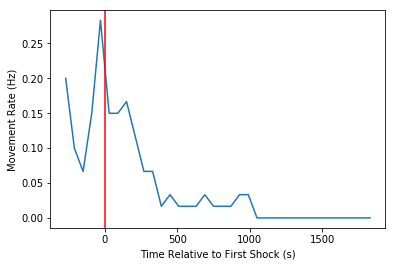

In [11]:
rate_window_starts = np.arange(-300,31*60,60) + fish.shock_st[0] #1 minutes windows around start of shock
rate_window_centers = rate_window_starts + 30
rate_windows_adj = rate_window_starts - fish.td_time[0] #corrected for the fact that get_movement_rate wants time relative to start of tail imaging.
plt.plot(rate_window_centers - fish.shock_st[0], [fish.get_movement_rate([x,x+60], bExcShockResp=False) for x in rate_windows_adj])
plt.axvline(0,c='r')
plt.ylabel('Movement Rate (Hz)')
plt.xlabel('Time Relative to First Shock (s)')

The `get_roi_table` method returns a dataframe of all the rois for teh fish.  Each row of this table represents an ROI and specified the place the ROI is in, the pixels that are included in the ROI, the centroid of the ROI, and which brain regions the ROI is in.  

Note, this data is older and was processed by simply segmenting the anatomical images.  Thus the data is does not look as clean as data that is cleaned up and processed using CNMF, for example.

In [12]:
df = fish.get_roi_table() #this can be slow to run the first time as data is loaded from files
df.head()

,fishid,z,zndx,roi_img_label,coords,centroid_x,centroid_y,area,solidity,eccentricity,...,in_l_tel,in_r_ctel,in_l_LHb,in_l_MHb,in_r_vthal,in_r_MHb,in_l_dthal,region,hemisphere,region_bilat
0,f01555,0,0,1,"[[1, 27], [1, 28], [2, 26], [2, 27], [2, 28], ...",2.200000,27.200000,10,0.909091,0.828852,...,False,False,False,False,False,False,False,other,w,other
1,f01555,0,1,2,"[[1, 56], [1, 57], [1, 58], [1, 59], [1, 60], ...",1.923077,57.692308,13,1.000000,0.774346,...,False,False,False,False,False,False,False,other,w,other
2,f01555,0,2,3,"[[1, 61], [1, 62], [1, 64], [1, 65], [2, 62], ...",2.076923,63.461538,13,0.764706,0.872165,...,False,False,False,False,False,False,False,other,w,other
3,f01555,0,3,4,"[[1, 83], [1, 84], [1, 85], [1, 86], [2, 82], ...",2.076923,84.384615,13,0.928571,0.656671,...,False,False,False,False,False,False,False,other,w,other
4,f01555,0,4,5,"[[1, 87], [1, 88], [1, 89], [1, 90], [1, 91], ...",3.517857,90.446429,56,0.767123,0.888139,...,False,False,False,False,False,False,False,l_wholebrain,l,wholebrain


'get_signals_raw' returns a matrix containing the raw fluorescent signal associated with each ROI.  Each row of this matrix is associated with the corresponding row of the ROI table.  

Note, I only use the second half of the signal matrix, because the agarose had not fully hardened during the first of imaging which cause the fish to drift in z slightly.

In [13]:
M = fish.get_signals_raw(z=None)
#M = hbutils.df_over_f(M)
print('Num ROIs:', df.shape[0])
print('Shape of signal matrix', M.shape)

Num ROIs: 15888
Shape of signal matrix (15888, 2826)


There are also various methods for grabbing the raw imaging data:  
get_tif_as_vol  
get_tif_rasl

We can use this to visualize a few ROIs in particular plane/slice and brain region:

(**This won't work on AWS unless you upload tif stacks**)

# Real data

In [14]:
from pandas import DataFrame

In [15]:
def moving_average(a, n=3) :
    ret = np.cumsum(a,0)
    ret[n:] = ret[n:] - ret[:-n]
    rm = ret[n - 1:] / n
    pad_start = np.full((n-1,rm.shape[1]), rm[0])
    return np.vstack([pad_start, rm])

def ewma(data,span):
    df = DataFrame(data)
    return df.ewm(span).mean().values

def df_f(x,ma_window=6,span=6):
    u = moving_average(x,ma_window)
    return ewma((x - u)/u, span)

In [16]:
Mdf = df_f(M.T)

In [17]:
dtype = np.float32
x_fish = T.from_numpy(Mdf.astype(dtype)).cuda()
time_fish = T.from_numpy(fish.frame_st.mean(1).astype(dtype)).cuda()
if dtype==np.float16:
    u_fish = T.cuda.HalfTensor(time_fish.shape).zero_()
    p_fish = T.cuda.HalfTensor(time_fish.shape).zero_()
else:
    u_fish = T.cuda.FloatTensor(time_fish.shape).zero_()
    p_fish = T.cuda.FloatTensor(time_fish.shape).zero_()
u_fish[numpy.searchsorted(fish.frame_et[:,-1], fish.shock_st,side="left")] = 1


In [ ]:
n_future_steps = 1
batch_size = 1

# data = FishSeqData(u_fish,p_fish,x_fish,n_future_steps)
# model = DynamicsSeq(data.nfeatures,n_future_steps,T.float16)
# train_fp16(model,data,15,(1e-4,1e-5),(1e-3,1e-4),lr=1e-3,verbose=False, loss_scale=512)

data = FishSeqData(u_fish,p_fish,x_fish,n_future_steps)
model = DynamicsSeq(data.nfeatures,n_future_steps)
train(model,data,20,(1e-3,1e-4),(1e-1,1e-2),lr=1e-2,verbose=False)

  0%|          | 0/2825 [00:00<?, ?it/s]

mse_loss: 73.4449462891


  0%|          | 0/2825 [00:00<?, ?it/s]

cum_loss: 13336264654.8, mse_loss: 71.5878215859


  0%|          | 0/2825 [00:00<?, ?it/s]

cum_loss: 588284640.562, mse_loss: 68.218532281


  0%|          | 0/2825 [00:00<?, ?it/s]

cum_loss: 558675451.75, mse_loss: 64.7992942668


  0%|          | 0/2825 [00:00<?, ?it/s]

cum_loss: 539864484.812, mse_loss: 61.5378791709


  0%|          | 0/2825 [00:00<?, ?it/s]

cum_loss: 521503757.25, mse_loss: 58.3193199907


  0%|          | 0/2825 [00:00<?, ?it/s]

cum_loss: 503592171.609, mse_loss: 55.2467442886


  0%|          | 0/2825 [00:00<?, ?it/s]

cum_loss: 486127826.938, mse_loss: 52.4311136582


  0%|          | 0/2825 [00:00<?, ?it/s]

cum_loss: 469108509.281, mse_loss: 49.6182296169


  0%|          | 0/2825 [00:00<?, ?it/s]

cum_loss: 452531716.641, mse_loss: 46.814604041


  0%|          | 0/2825 [00:00<?, ?it/s]

cum_loss: 436394682.234, mse_loss: 44.2507965088


  0%|          | 0/2825 [00:00<?, ?it/s]

cum_loss: 420694358.75, mse_loss: 41.7524754362


  0%|          | 0/2825 [00:00<?, ?it/s]

cum_loss: 405427402.078, mse_loss: 39.4550936522


  0%|          | 0/2825 [00:00<?, ?it/s]

cum_loss: 390589880.344, mse_loss: 37.1856032216


  0%|          | 0/2825 [00:00<?, ?it/s]

cum_loss: 376177738.93, mse_loss: 35.0808268918


  0%|          | 0/2825 [00:00<?, ?it/s]

cum_loss: 362186675.109, mse_loss: 32.9659454957


  0%|          | 0/2825 [00:00<?, ?it/s]

cum_loss: 348612081.039, mse_loss: 31.0570395408


  0%|          | 0/2825 [00:00<?, ?it/s]

cum_loss: 335449053.0, mse_loss: 29.1456321985


 81%|████████  | 2276/2825 [08:08<01:57,  4.66it/s]

In [ ]:
print("loss if A=B=C=zeros: {}".format(T.abs(x_fish[1:])/(x_fish.shape[0]-1)))

In [ ]:
T.save(model.state_dict(),"fish_dcm_fp32_sgd_epoch=20,lA=(1e-3,1e-4),lB=(1e-1,1e-2),lr=1e-2")

In [ ]:
plt.imshow(model.A[:100,:100].cpu().detach().numpy())
plt.colorbar()
plt.show()

In [ ]:
x_fish[0].sum()

In [ ]:
x_fish[0,:20]

In [ ]:
model(u_fish[None,None,0],p_fish[None,None,0],x_fish[None,[0]],1).squeeze()

In [ ]:
x_fish[0]

In [ ]:
plt.imshow(model.B[:100,:100].cpu().detach().numpy())
plt.colorbar()
plt.show()

# Generate Half precision

In [4]:
ntime = 2826
nstim = 30
nfeatures = 15888

u_train = T.cuda.HalfTensor(ntime).uniform_()
p_train = T.cuda.HalfTensor(ntime).uniform_()
time_train = T.arange(ntime).half().cuda()
x_train = T.cuda.HalfTensor(ntime,nfeatures).uniform_()

In [5]:
(ntime*3+ntime*nfeatures)*16/1024**3

0.66918084025383

In [6]:
n_future_steps = 1
batch_size = 1

data = FishSeqData(u_train,p_train,x_train,n_future_steps)

In [7]:
model = DynamicsSeq(data.nfeatures,n_future_steps,T.float16,1e-4)

In [8]:
train_fp16(model,data,15,(1e-4,1e-5),(1e-3,0),lr=1e-3,verbose=False, loss_scale=512)
time_test, u_test, p_test, x_test = test_data
model_v_truth(model, u_test, p_test, x_test, A_true.data, B_true.data)

  0%|          | 2/2825 [00:00<03:56, 11.93it/s]

pred loss: inf



  5%|▌         | 142/2825 [00:11<03:32, 12.65it/s]

KeyboardInterrupt: 

  5%|▌         | 142/2825 [00:29<09:26,  4.73it/s]

# Generate float

In [4]:
ntime = 2826
nstim = 30
nfeatures = 15888

u_train = T.cuda.FloatTensor(ntime).uniform_()
p_train = T.cuda.FloatTensor(ntime).uniform_()
time_train = T.arange(ntime).cuda()
x_train = T.cuda.FloatTensor(ntime,nfeatures).uniform_()

In [5]:
n_future_steps = 1
batch_size = 1

data = FishSeqData(u_train,p_train,x_train,n_future_steps)
model = DynamicsSeq(data.nfeatures,n_future_steps)

In [ ]:
train(model,data,1,(1e-4,1e-5),(1e-3,1e-4),lr=0.1,verbose=False)
# time_test, u_test, p_test, x_test = test_data
# model_v_truth(model, u_test, p_test, x_test, A_true.data, B_true.data)

 30%|███       | 856/2825 [03:26<07:54,  4.15it/s]

# Sim 

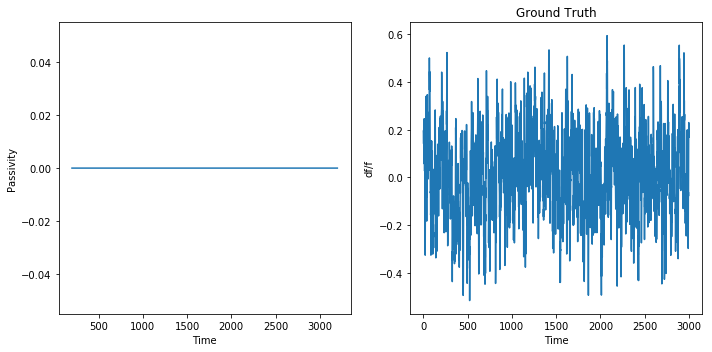

In [4]:
ntime = 3000
nstim = 30
nfeatures = 10
A_true, B_true, C_true, train_data, test_data = generate_data(ntime, nstim,nfeatures,burn_in=200, e=0.1,k=1,t0=1e10)

time_train, u_train, p_train, x_train = train_data
time_test, u_test, p_test, x_test = test_data

scale = 8

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(time_train,p_train.cpu().numpy())
ax[0].set_ylabel("Passivity")
ax[0].set_xlabel("Time")

ax[1].plot(x_train[:,2].cpu().numpy())
ax[1].set_title("Ground Truth")
ax[1].set_ylabel("df/f")
ax[1].set_xlabel("Time")
fig.tight_layout()
fig

In [5]:
n_future_steps = 1
batch_size = 10

data = FishSeqData(u_train,p_train,x_train,n_future_steps)
model = DynamicsSeq(data.nfeatures,n_future_steps)

In [6]:
train(model,data,8,(1e-4,0),(1e-3,1e-4),lr=1e-2)

  1%|          | 3/300 [00:00<00:10, 29.06it/s]

A_loss: 1.22243654728
epoch 0: 

  1%|          | 3/300 [00:00<00:10, 27.02it/s]

pred_loss: 31.9146524547, A_loss: 0.041522115469, B_loss: 0.0212900880724, C_loss: 0.407817751169
pred_loss: 31.9146524547
epoch 1: 

  1%|▏         | 4/300 [00:00<00:09, 31.42it/s]

pred_loss: 4.41125610983, A_loss: 0.00106719601899, B_loss: 0.0213134605438, C_loss: 0.147408589721
pred_loss: 4.41125610983
epoch 2: 

  1%|▏         | 4/300 [00:00<00:09, 31.33it/s]

pred_loss: 3.40441890107, A_loss: 0.000590472307522, B_loss: 0.0213184133172, C_loss: 0.0456914715469
pred_loss: 3.40441890107
epoch 3: 

  1%|▏         | 4/300 [00:00<00:09, 30.74it/s]

pred_loss: 3.21544327168, A_loss: 0.000612090167124, B_loss: 0.0213361550122, C_loss: 0.0144518595189
pred_loss: 3.21544327168
epoch 4: 

  1%|▏         | 4/300 [00:00<00:09, 31.61it/s]

pred_loss: 3.15928539773, A_loss: 0.000536397274118, B_loss: 0.0213139038533, C_loss: 0.00340078724548
pred_loss: 3.15928539773
epoch 5: 

  1%|▏         | 4/300 [00:00<00:09, 31.41it/s]

pred_loss: 3.14922978915, A_loss: 0.000806712138001, B_loss: 0.0213187746704, C_loss: 0.00359702995047
pred_loss: 3.14922978915
epoch 6: 

  1%|▏         | 4/300 [00:00<00:09, 31.60it/s]

pred_loss: 3.14814150054, A_loss: 0.000945926294662, B_loss: 0.0213333647698, C_loss: 0.00277419132181
pred_loss: 3.14814150054
epoch 7: 

100%|██████████| 300/300 [00:09<00:00, 30.81it/s]

pred_loss: 3.15451791417, A_loss: 0.000647119188216, B_loss: 0.0213116630912, C_loss: 0.00251636886969
pred_loss: 3.15451791417
pred_loss: 3.15451791417, A_loss: 0.000647119188216, B_loss: 0.0213116630912, C_loss: 0.00251636886969


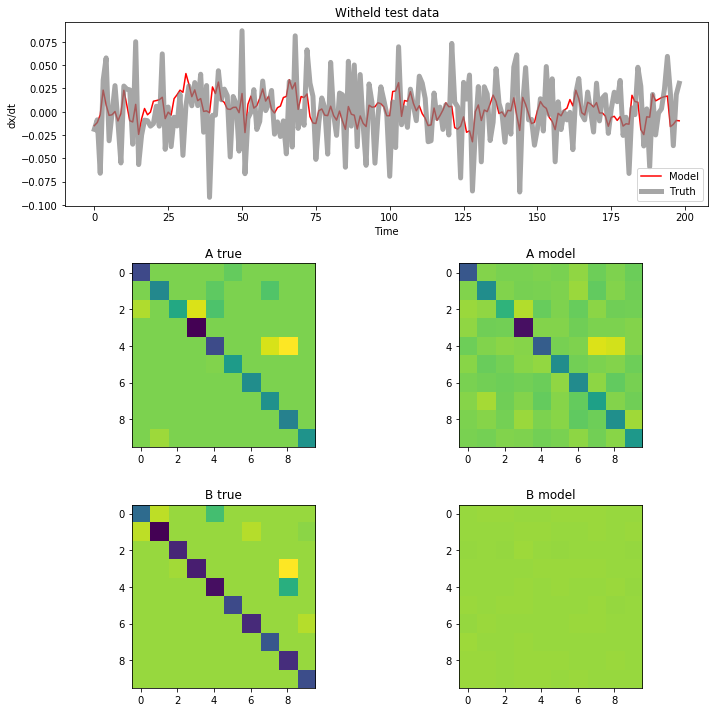

In [7]:
model_v_truth(model, u_test, p_test, x_test, A_true.data, B_true.data)

In [ ]:
n_future_steps = 1
batch_size = 1

scale = 1
time_train, u_train, p_train, x_train = time_train, u_train.half()*scale, p_train.half()*scale, x_train.half()*scale
time_test, u_test, p_test, x_test = time_test, u_test.half()*scale, p_test.half()*scale, x_test.half()*scale
data = FishSeqData(u_train,p_train,x_train,n_future_steps)
model = DynamicsSeq(data.nfeatures,n_future_steps,T.float16,scale)
train_fp16(model,data,15,(1e-4,1e-5),(1e-3,0),lr=1e-3,verbose=True, loss_scale=512)

model_v_truth(model, u_test, p_test, x_test, A_true.data, B_true.data)

  2%|▏         | 56/2999 [00:00<00:05, 553.60it/s]

A_loss: 1.14885008335
epoch 0: 

  2%|▏         | 57/2999 [00:00<00:05, 564.95it/s]

pred_loss: 970.302741691, A_loss: 1.12238240242, B_loss: 1.18244886398, C_loss: 0.361779123545
pred_loss: 970.302741691
epoch 1: 

  2%|▏         | 57/2999 [00:00<00:05, 561.87it/s]

pred_loss: 953.002928384, A_loss: 1.09656023979, B_loss: 1.17737352848, C_loss: 0.357613861561
pred_loss: 953.002928384
epoch 2: 

  2%|▏         | 57/2999 [00:00<00:05, 562.70it/s]

pred_loss: 936.106647916, A_loss: 1.07136487961, B_loss: 1.17231607437, C_loss: 0.353502690792
pred_loss: 936.106647916
epoch 3: 

  2%|▏         | 55/2999 [00:00<00:05, 541.14it/s]

pred_loss: 919.627376951, A_loss: 1.04678177834, B_loss: 1.16727638245, C_loss: 0.349444180727
pred_loss: 919.627376951
epoch 4: 

  2%|▏         | 55/2999 [00:00<00:05, 541.26it/s]

pred_loss: 903.539994083, A_loss: 1.02279376984, B_loss: 1.16225421429, C_loss: 0.345437914133
pred_loss: 903.539994083
epoch 5: 

  2%|▏         | 55/2999 [00:00<00:05, 542.59it/s]

pred_loss: 887.845618337, A_loss: 0.99938672781, B_loss: 1.15724682808, C_loss: 0.341483682394
pred_loss: 887.845618337
epoch 6: 

  2%|▏         | 57/2999 [00:00<00:05, 562.17it/s]

pred_loss: 872.519791916, A_loss: 0.976547181606, B_loss: 1.15225625038, C_loss: 0.337580174208
pred_loss: 872.519791916
epoch 7: 

  2%|▏         | 57/2999 [00:00<00:05, 565.03it/s]

pred_loss: 857.576278865, A_loss: 0.954258739948, B_loss: 1.14728271961, C_loss: 0.333726584911
pred_loss: 857.576278865
epoch 8: 

  2%|▏         | 57/2999 [00:00<00:05, 562.36it/s]

pred_loss: 842.993564084, A_loss: 0.932507574558, B_loss: 1.14232373238, C_loss: 0.329922020435
pred_loss: 842.993564084
epoch 9: 

 65%|██████▌   | 1959/2999 [00:03<00:01, 552.78it/s]